In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['figure.dpi'] = 150
warnings.simplefilter(action='ignore', category=FutureWarning)

# Asset Allocation in Python

## Evaluating the performance of a basic 1/n portfolio

### How to do it...

1. Import the libraries:

In [3]:
# !pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
# !pip install pyfolio
import pyfolio as pf

C:\Users\tongt\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


2. Set up the parameters:

In [4]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

3. Download the stock prices from Yahoo Finance:

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


<AxesSubplot:title={'center':'Stock prices of the considered assets'}, xlabel='Date'>

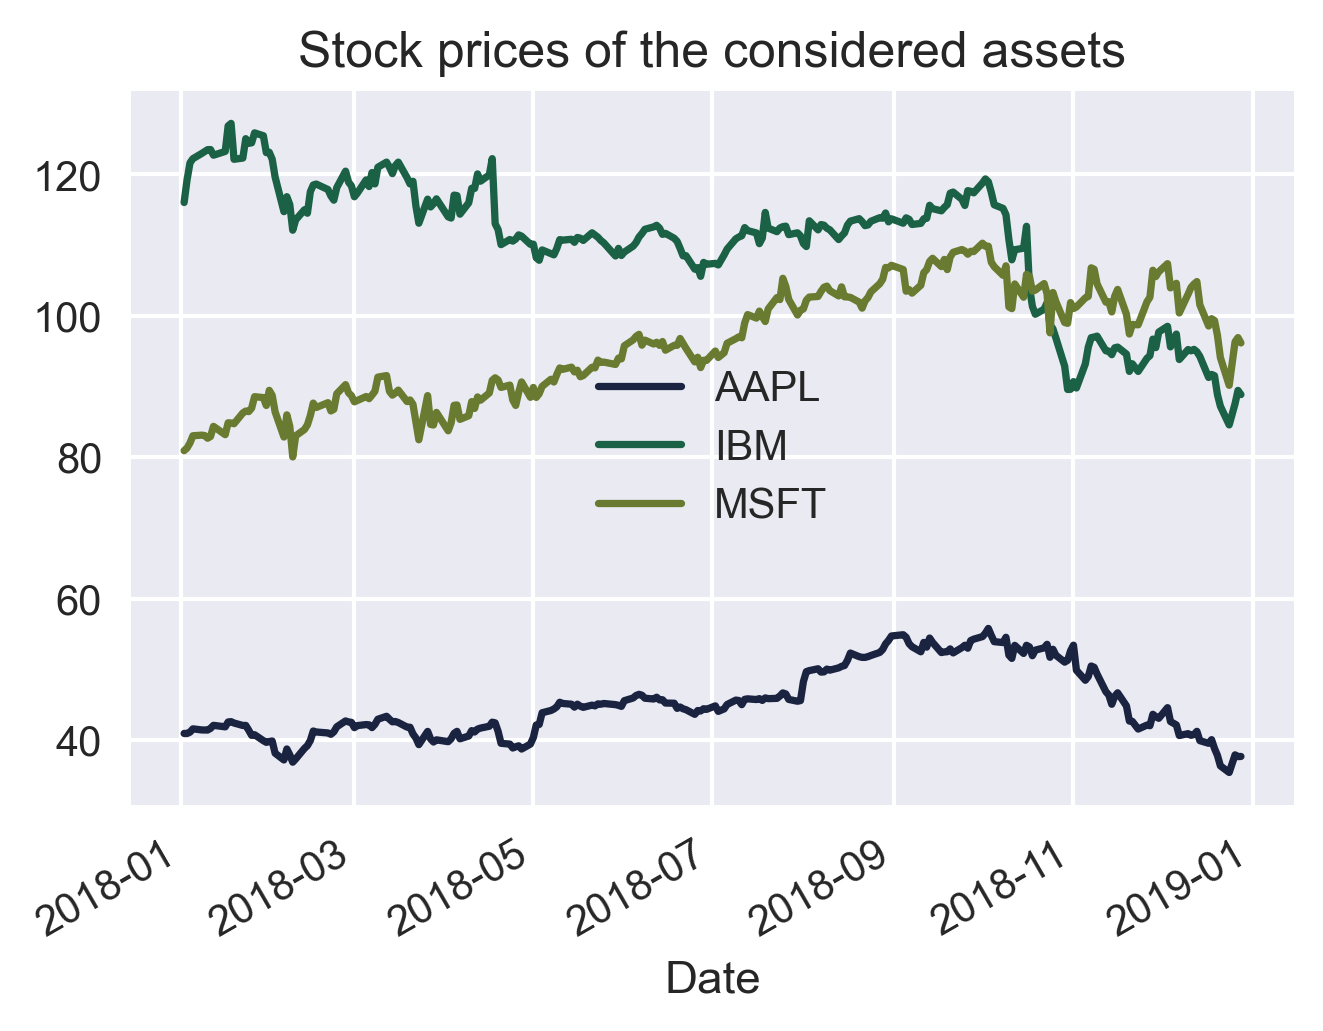

In [5]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')

4. Calculate individual asset returns:

In [6]:
returns = prices_df['Adj Close'].pct_change().dropna()

5. Define the weights:

In [7]:
portfolio_weights = n_assets * [1/n_assets]

6. Calculate portfolio returns:

In [8]:
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), 
                              index=returns.index)
# Comment: 총 4개의 주식에 동일한 비중으로 돈을 투자한다고 가정 (portoflio_weight 정의를 참고)
# np.dot (행렬곱셈): 동일한 비중으로 돈이 투자된 경우 (portfolio_weights), 과거 2017~2018년 동안 각 주식 수익률의 데이터(returns.T)에 해당 비중을 곱하는 작업 
# 각 비중(portfolio_weight)이 곱해진 주식들의 가중 평균 수익률 = W1 * R_1 + W2 * R_2 + W3* R_3 + W4 * R_4 (LINEAR COMBINATION: 선형조합) 
# 그것을 portfolio_returns 라고 부름  

7. Create the tear sheet (simple variant):

Start date,2018-01-03
End date,2018-12-28
Total months,11
,Backtest
Annual return,-4.8%
Cumulative returns,-4.8%
Annual volatility,23.3%
Sharpe ratio,-0.10
Calmar ratio,-0.17
Stability,0.12
Max drawdown,-27.9%


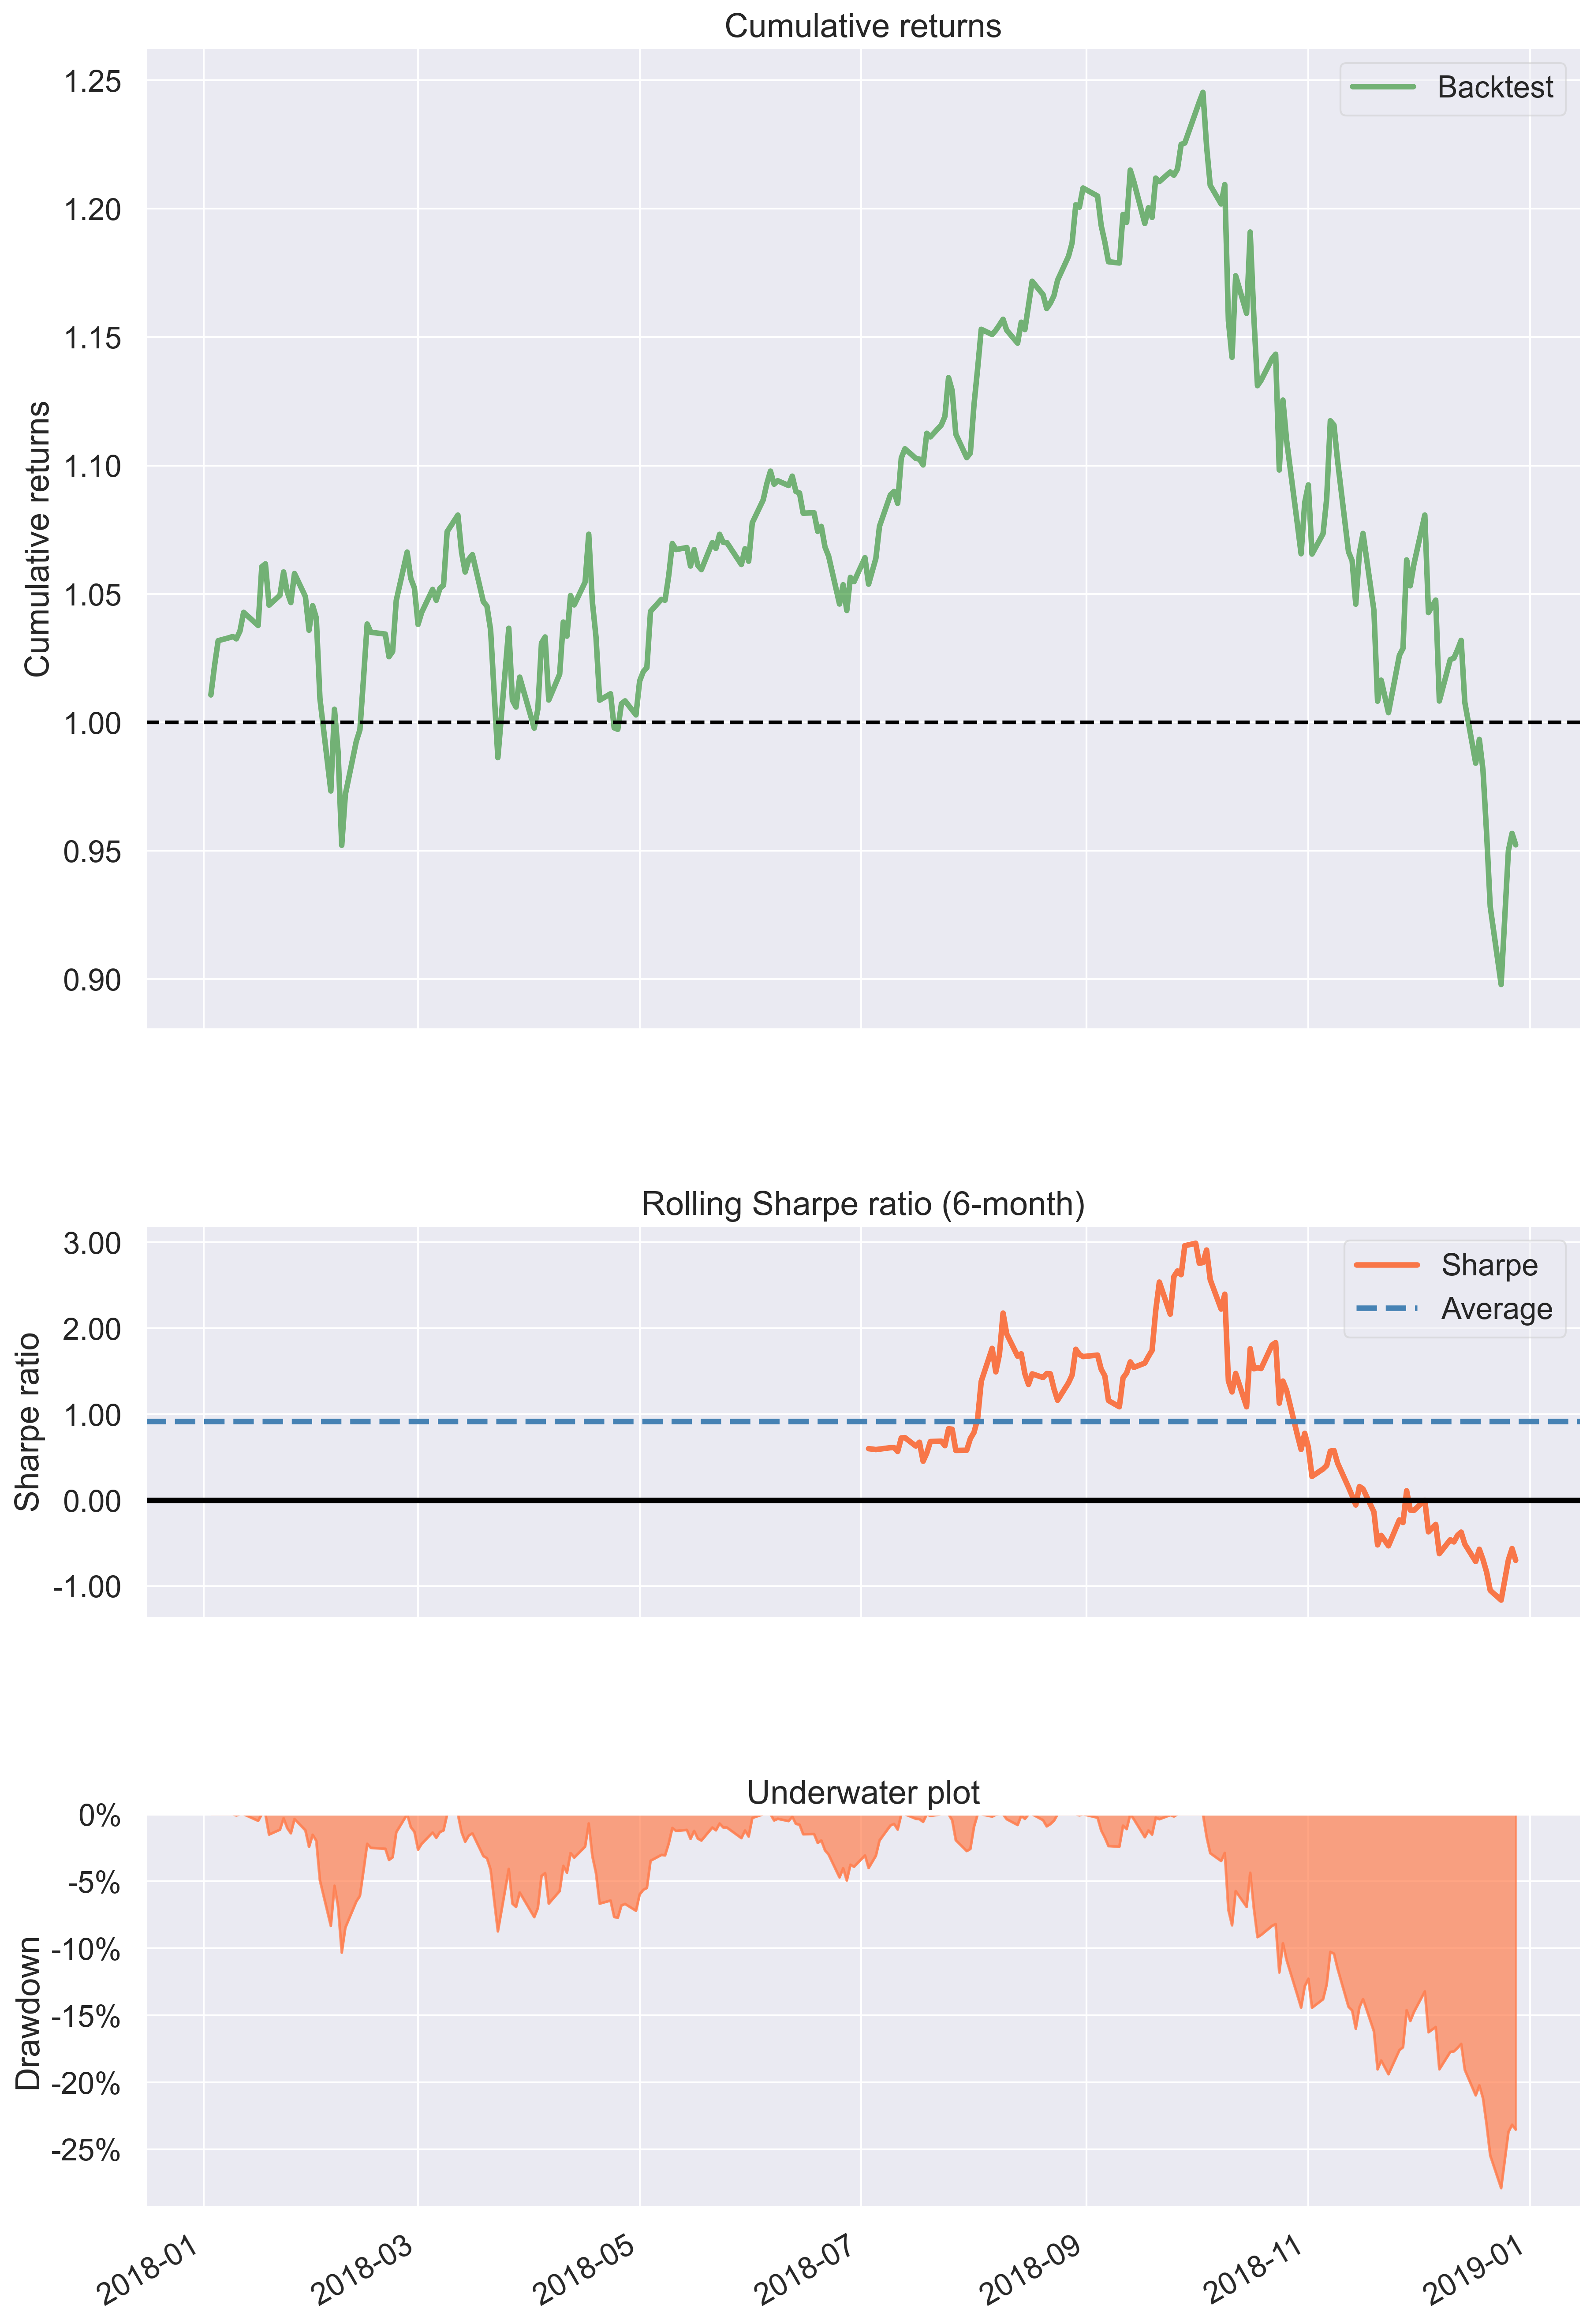

In [9]:
pf.create_simple_tear_sheet(portfolio_returns)

## Finding the Efficient Frontier using Monte Carlo simulations

### How to do it...

1. Import the libraries:

In [10]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Set up the parameters:

In [11]:
N_PORTFOLIOS = 10 ** 5 
N_DAYS = 252 
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

3. Download the stock prices from Yahoo Finance:

In [12]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


<AxesSubplot:title={'center':'Stock prices of the considered assets'}, xlabel='Date'>

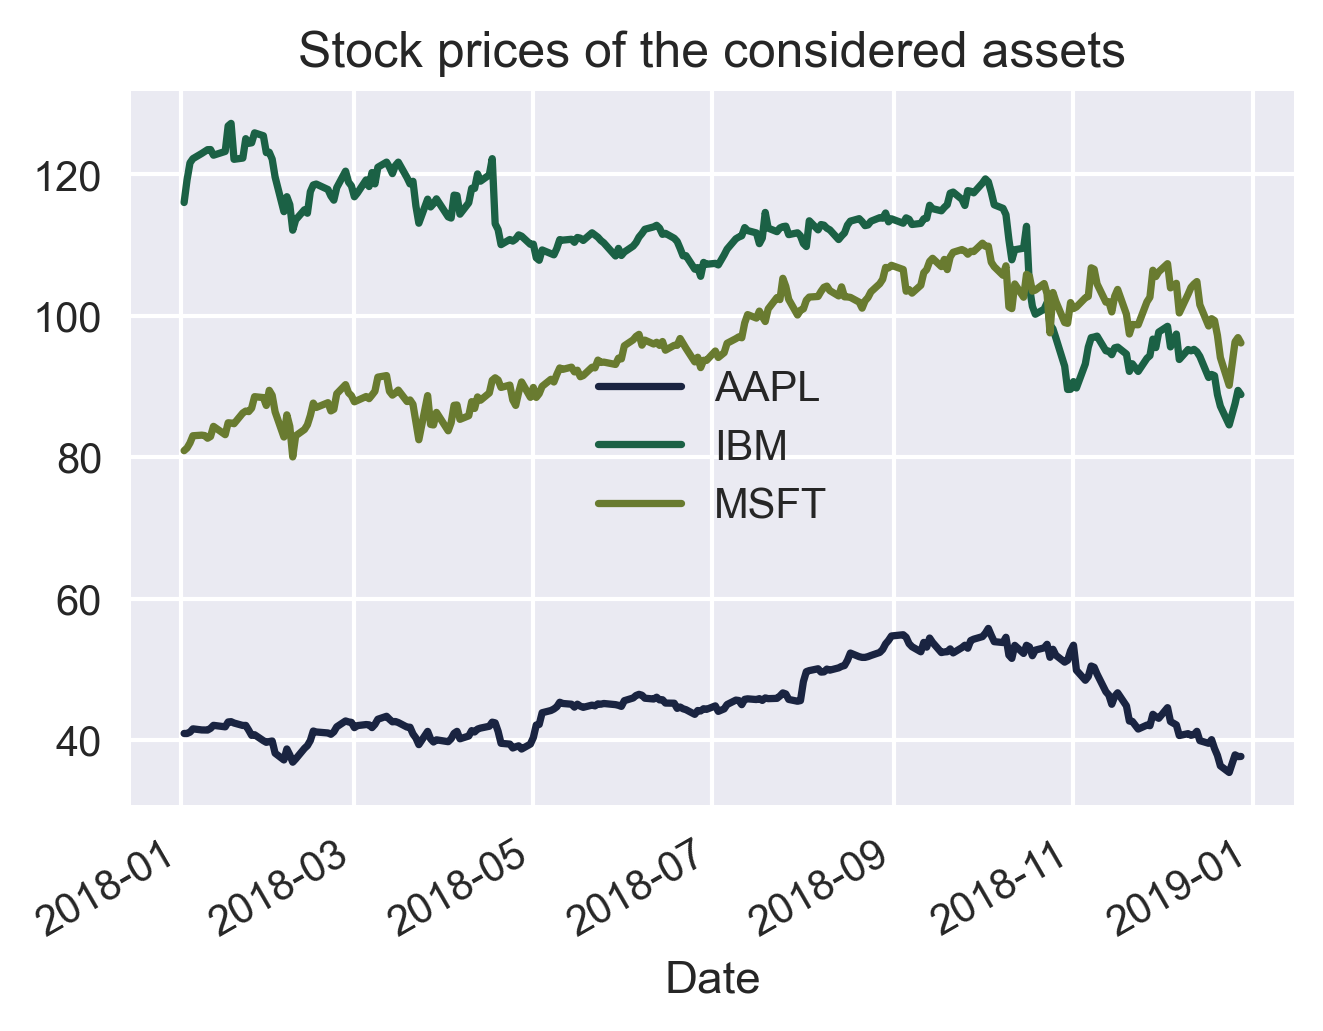

In [13]:
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')

4. Calculate annualized average returns and the corresponding standard deviation:

In [14]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

<AxesSubplot:title={'center':'Daily returns of the considered assets'}, xlabel='Date'>

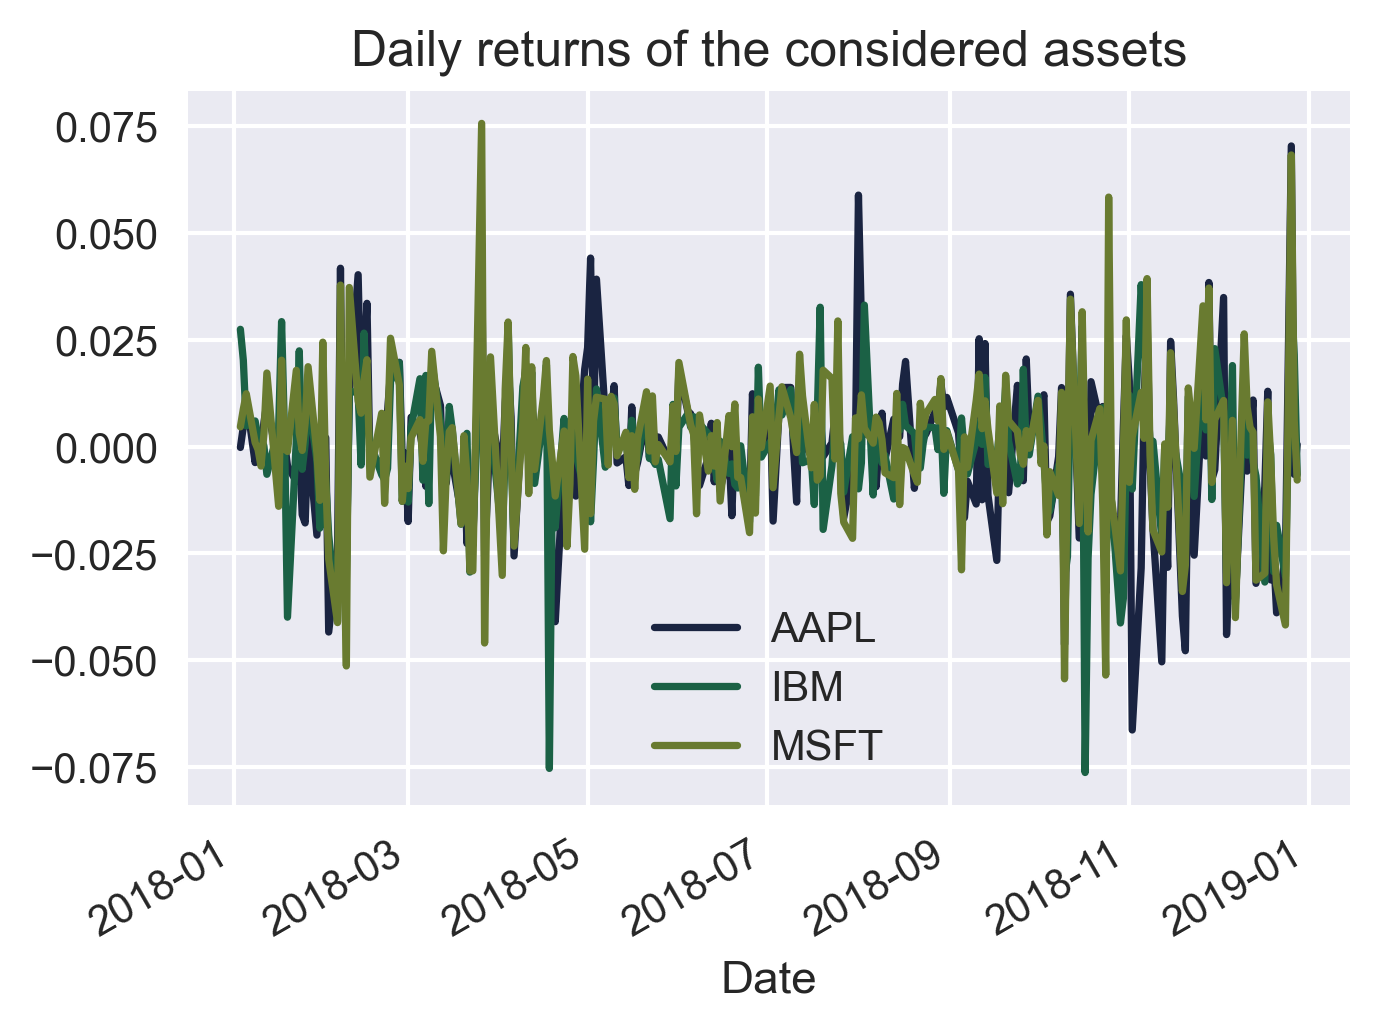

In [15]:
returns_df.plot(title = 'Daily returns of the considered assets')

5. Simulate random portfolio weights:

In [16]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
# Return random floats in the half-open interval [0.0, 1.0) 
# Results are from the "continuous uniform" distribution over the stated interval.

weights /= np.sum(weights, axis=1)[:,np.newaxis]
# /= is equivalent to x = x/3 

6. Calculate portfolio metrics:

In [17]:
  portf_rtns = np.dot(weights,avg_returns)

  portf_vol = []
  for i in range(0, len(weights)): 
      portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                      np.dot(cov_mat, weights[i]))))
  

  portf_vol = np.array(portf_vol) 
  portf_sharpe_ratio = portf_rtns / portf_vol 
  
# Sharpe ratio = (mu - r_f) / (volatility) = ([w1,...,w4]*[r_1, ..., r_4]' - risk free rate) / sqrt( [(w1),(w2),... (w4)]*VAR-COV* [(w1),(w2),...,(w4)]')

7. Create a joint DataFrame with all data:

In [18]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol, 
                                 'sharpe_ratio': portf_sharpe_ratio})


8. Locate the points creating the Efficient Frontier:

In [19]:
N_POINTS = 100 
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)

portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS): 
    if portf_rtns_ef[point_index] not in portf_rtns: 
         indices_to_skip.append(point_index) 
         continue 
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index]) 
    # return elements chosen from x or y depending on condition
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

9. Plot the Efficient Frontier:

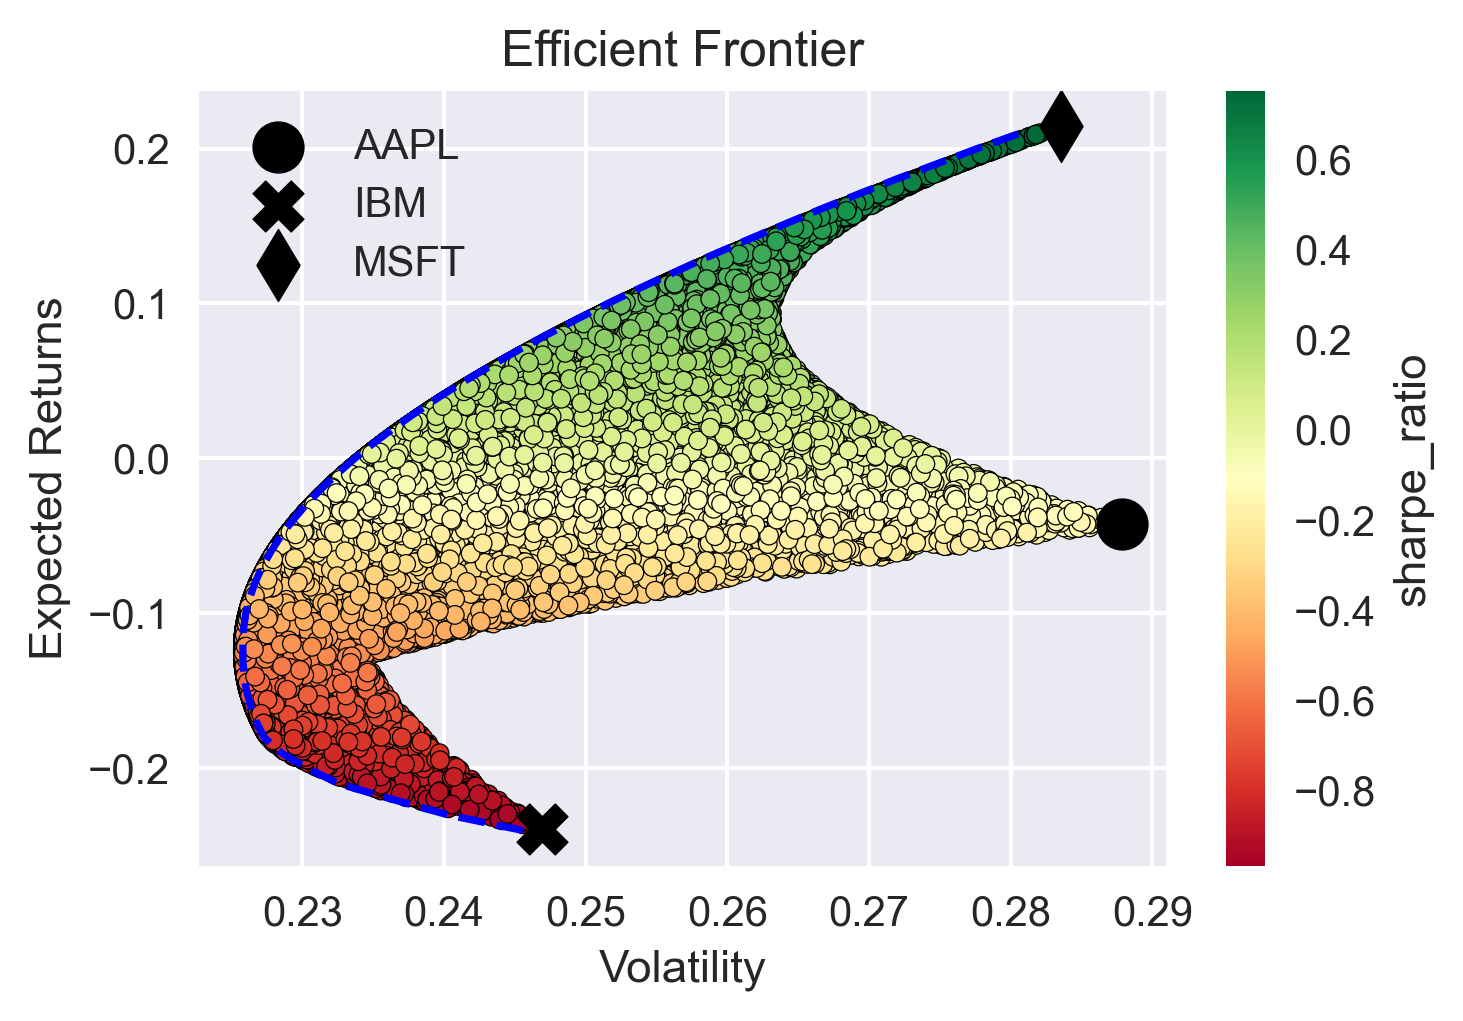

In [20]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.show()


### There's more

In [21]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
#np.argmax: returns the indices of the maximum values along an axis 

max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
# Access a group of rows and columns by label(s) or a boolean array. 

min_vol_ind = np.argmin(portf_results_df.volatility)

min_vol_portf = portf_results_df.loc[min_vol_ind]

In [22]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 21.28% volatility: 28.30% sharpe_ratio: 75.20% 
Weights
AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

In [23]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -12.38% volatility: 22.58% sharpe_ratio: -54.84% 
Weights
AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

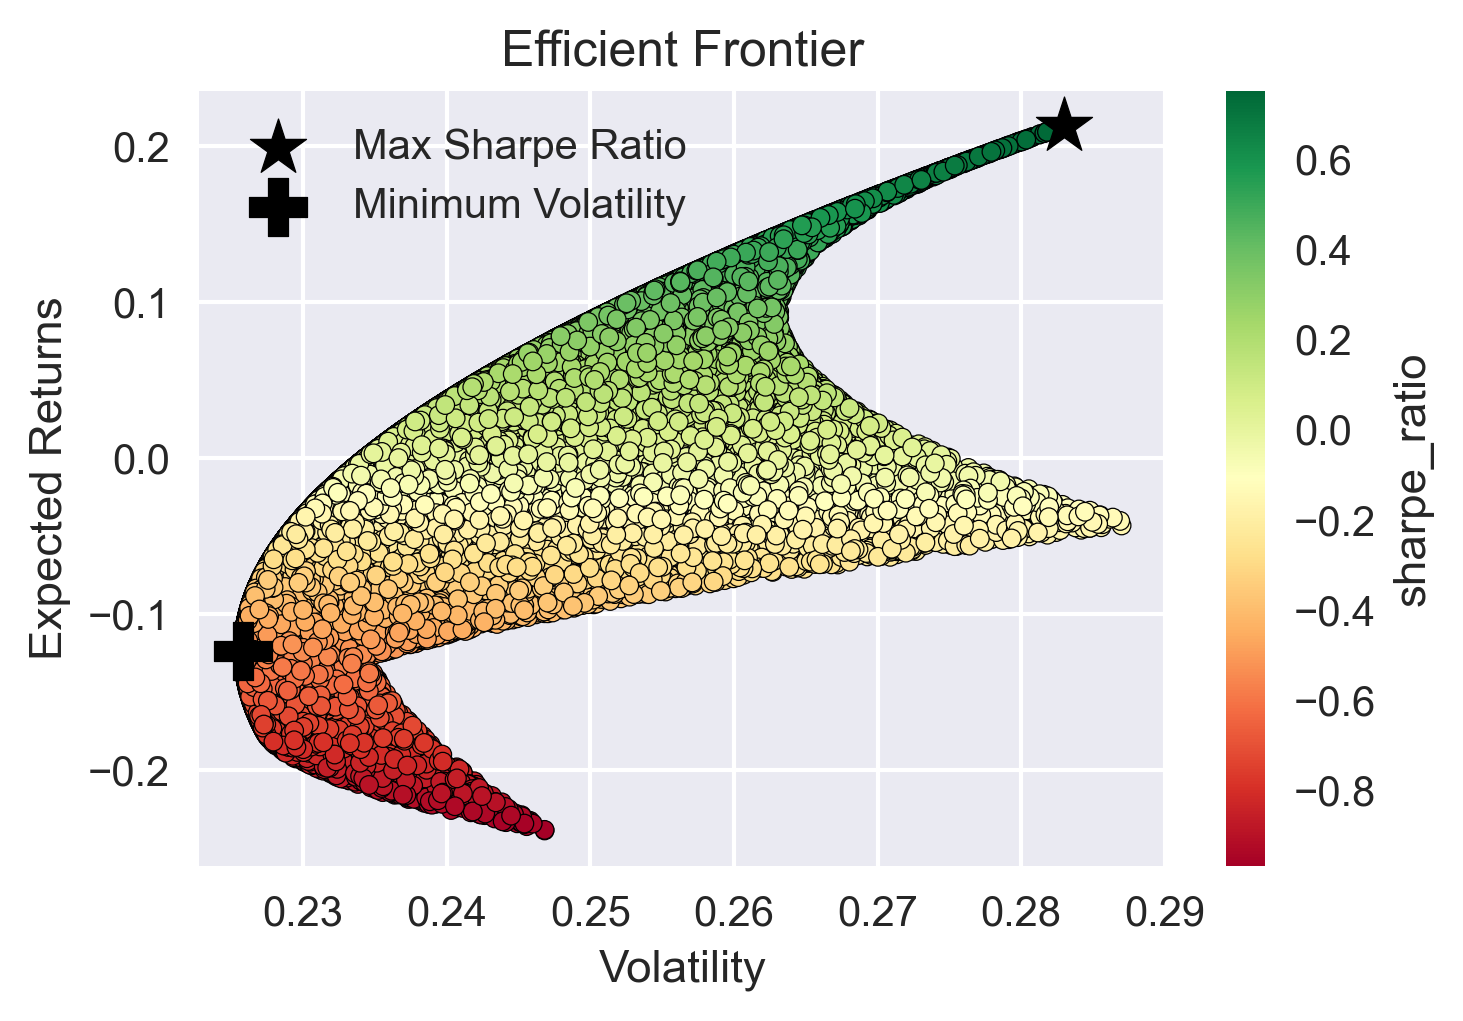

In [24]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.show()

## Finding the Efficient Frontier using optimization with scipy

### Getting Ready

This recipe requires running all the code from the recipe *Finding the Efficient Frontier using Monte Carlo simulations*.

### How to do it...

1. Import the libraries:

In [25]:
import numpy as np 
import scipy.optimize as sco

2. Define functions calculating portfolio returns and volatility:

In [26]:
def get_portf_rtn(w,ave_rtns): 
    return np.sum(ave_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat): 
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

3. Define the function calculating the efficient frontier:

In [27]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range): 

    efficient_portfolios = []

    n_assets = len(avg_returns) 
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for assets in range(n_assets)) 
    initial_guess = n_assets * [1. / n_assets, ] # length: 4 assets with 0.25 

    for ret in rtns_range: 
        constraints = ({'type': 'eq', 
                       'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret}, 
                      {'type': 'eq', 
                       'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args = args, method = 'SLSQP', 
                                           constraints = constraints,
                                           bounds = bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios     

4. Define the considered range of returns:

In [28]:
rtns_range = np.linspace(-0.22, 0.32, 200)

5. Calculate the Efficient Frontier:

In [29]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

6. Extract the volatilities of the efficient portfolios:

In [30]:
vols_range = [x['fun'] for x in efficient_portfolios]

7. Plot the calculated Efficient Frontier, together with the simulated portfolios:

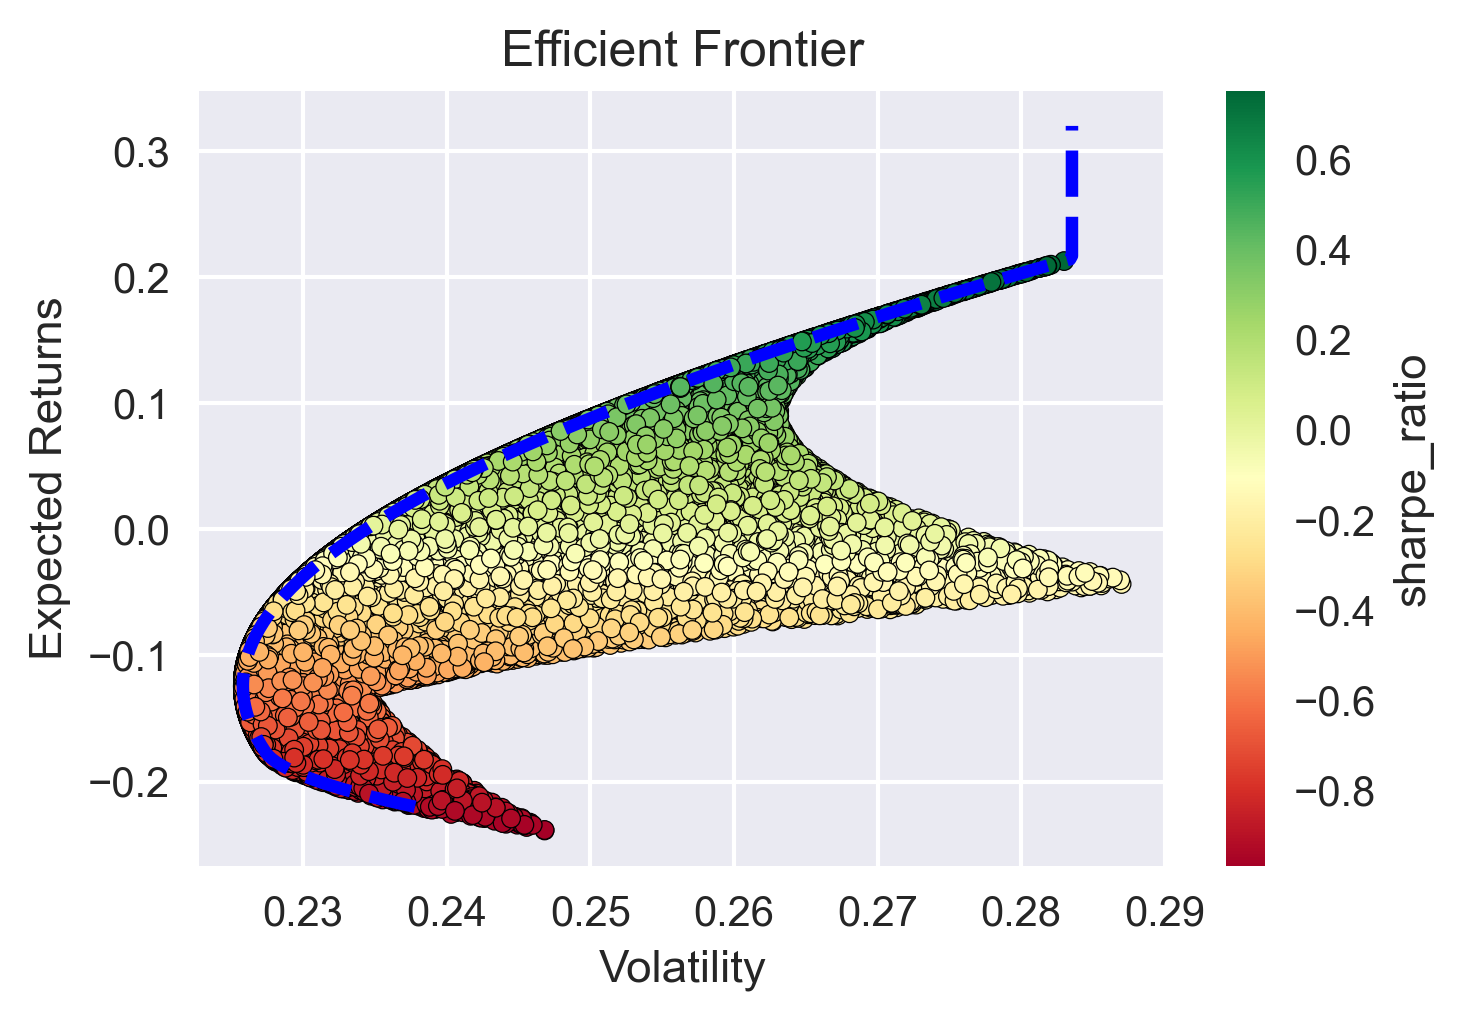

In [31]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

plt.tight_layout()
plt.show()

8. Identify the minimum volatility portfolio:

In [32]:
min_vol_ind = np.argmin(vols_range) 
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol, 
                 'Sharpe Ratio': (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}

min_vol_portf

{'Return': -0.1250251256281407,
 'Volatility': 0.22580489681068222,
 'Sharpe Ratio': -0.5536865116479888}

9. Print performance summary:

In [33]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: -12.50% Volatility: 22.58% Sharpe Ratio: -55.37% 
Weights
AAPL: 28.04% IBM: 58.98% MSFT: 12.98% 

### There's more

1. Define the objective function:

In [34]:
# min - sharpe ratio (negative sharpe ratio)
# max sharpe ratio 

def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate): 
    portf_returns = np.sum(avg_rtns * w) 
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility 
    return -portf_sharpe_ratio 

2. Find the optimized portfolio:

In [35]:
n_assets = len(avg_returns) 
RF_RATE = 0 

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x)-1})
bounds = tuple((0,1) for asset in range(n_assets)) 
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)


3. Extract information about the maximum Sharpe Ratio portfolio:

In [36]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}
max_sharpe_portf

{'Return': 0.2145814925870816,
 'Volatility': 0.2835381638486236,
 'Sharpe Ratio': 0.7567993305537632}

4. Print performance summary:

In [37]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 21.46% Volatility: 28.35% Sharpe Ratio: 75.68% 
Weights
AAPL: 0.00% IBM: 0.00% MSFT: 100.00% 

## Finding the Efficient Frontier using convex optimization with cvxpy

### Getting Ready

This recipe requires running all the code from the previous recipes:
* *Finding the Efficient Frontier using Monte Carlo simulations*
* *Finding the Efficient Frontier using optimization with scipy*

### How to do it...

1. Import the libraries:

In [38]:
import cvxpy as cp

ModuleNotFoundError: No module named 'cvxpy'

2. Convert the annualized average returns and the covariance matrix to `numpy` arrays:

In [ ]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values 

3. Set up the optimization problem:

In [ ]:
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg = True)
portf_rtn_cvx = avg_returns * weights 
portf_vol_cvx = cp.quad_form(weights,cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma*portf_vol_cvx)
problem = cp.Problem(objective_function, 
                     [cp.sum(weights) == 1, weights >= 0])

4. Calculate the Efficient Frontier:

In [ ]:
N_POINTS = 25 
portf_rtn_cvx_ef = np.zeros(N_POINTS)
portf_vol_cvx_ef = np.zeros(N_POINTS) 
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for i in range(N_POINTS): 
    gamma.value = gamma_range[i]
    problem.solve() 
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value 
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value 
    weights_ef.append(weights.value)


5. Plot the allocation for different values of the risk-aversion parameter: (gamma)

In [ ]:
weights_df = pd.DataFrame(weights_ef, 
                          columns=RISKY_ASSETS, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True) 
ax.set(title='Weights allocation per risk-aversion level',
       xlabel=r'$\gamma$', 
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

6. Plot the Efficient Frontier, together with the individual assets:

In [ ]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                 marker=MARKS[asset_index], 
                 label=RISKY_ASSETS[asset_index],
                 s=150)
ax.set(title='Efficient Frontier',
       xlabel='Volatility', 
       ylabel='Expected Returns', )
ax.legend()

plt.tight_layout()
plt.show()

### There's more

In [ ]:
x_lim = [0.25, 0.6]
y_lim = [0.125, 0.325]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Efficient Frontier - Minimized Volatility',
          xlabel='Volatility', 
          ylabel='Expected Returns',
          xlim=x_lim, 
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Efficient Frontier - Maximized Risk-Adjusted Return',
          xlabel='Volatility', 
          ylabel='Expected Returns',
          xlim=x_lim, 
          ylim=y_lim)

plt.tight_layout()
plt.show()

In [ ]:
max_leverage = cp.Parameter()
problem_with_leverage = cp.Problem(objective_function, 
                                   [cp.sum(weights) == 1, 
                                    cp.norm(weights, 1) <= max_leverage])

In [ ]:
LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25 

portf_vol_l_ef = np.zeros((N_POINTS, len_leverage))
portf_rtn_l_ef = np.zeros((N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))

for lev_ind, leverage in enumerate(LEVERAGE_RANGE): 
    for gamma_ind in range(N_POINTS): 
        max_leverage.value = leverage 
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve()
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value 
        weights_ef[lev_ind, gamma_ind, :] = weights.value 

In [ ]:
fig, ax = plt.subplots()

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l_ef[:, leverage_index], 
             portf_rtn_l_ef[:, leverage_index], 
             label=f'{leverage}')

ax.set(title='Efficient Frontier for different max leverage',
       xlabel='Volatility', 
       ylabel='Expected Returns')
ax.legend(title='Max leverage')

plt.tight_layout()
#plt.savefig('images/ch7_im18.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame(weights_ef[ax_index], 
                              columns=RISKY_ASSETS, 
                              index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar', 
                    stacked=True, 
                    ax=ax[ax_index], 
                    legend=None) 
    ax[ax_index].set(ylabel=(f'max_leverage = {LEVERAGE_RANGE[ax_index]}' 
                             '\n weight'))

    
ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1)) 
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)

plt.tight_layout()
#plt.savefig('images/ch7_im19.png')
plt.show()